# Spotify Milestone 2:  Team 20
## EDA and Baseline Model
Erik Subatis, Ankit Bhargava, Mark McDonald


In [3]:
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format ='retina'

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import json
import seaborn as sns
import time
import random
from scipy import stats

from sqlalchemy.ext.declarative import declarative_base 
from sqlalchemy import Table, Column, Integer, String, MetaData, and_, or_, func,distinct

%matplotlib inline

In [5]:
import importlib

sys.path.append('../../')
from spotify_api import get_spotify_data, get_tracks, get_artists, get_audiofeatures
from spotify_database import get_session, display_time
from spotify_utils import Table_Generator, List_Generator, pickle_load, pickle_save

In [5]:
# from tqdm import tqdm_notebook as tqdm
from tqdm.autonotebook import tqdm
tqdm.pandas()

In [2]:
# Word2Vec modules for baseline model 1
from gensim.models import Word2Vec
from gensim import utils
import gensim.models
from gensim.models import KeyedVectors

ModuleNotFoundError: No module named 'gensim'

In [6]:
# SKLearn for baseline module 2
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors

# **Index**

<a name='index'></a>
<a href=#s1>1. Overview</a>

<a href=#s2>2. Local Setup</a>

<a href=#s3>3. Test Database and Spotify Connections</a>

<a href=#s4>4. Review DataBase Structure</a>

<a href=#s5>5. NaN Values and Other Data Cleanup</a>

<a href=#s6>6. Basic Counts</a>
<br><a href=#s6a>6a. Playlists</a>
<br><a href=#s6b>6b. Artists</a>
<br><a href=#s6c>6c. Tracks</a>


<a href=#s7>7. Baseline Model 1 (Gensim)</a>

<a href=#s8>8. Baseline Model 2 (Collaborative Filtering / kNN)</a>

<a name='s1'></a>
# 1. Overview
<a href=#index>back to index</a>


### Database
The spotify data was distributed as 1,000 CSV files containing 1,000,000 playlists of songs. These files were imported to a SQLite database.  In addition to the CSV data stored in a Playlists table, additional tables were created for Artists and Tracks where additional data pulled from the Spotify API is stored.

### Support API's
In an effort to simplify access to the database and Spotify data, wrapper api's were created to similify access to the database and Spotify data. Additional utilities were created to support generating data for large volume iterations. (Modules created: `spotify_api`, `spotify_database`, `spotify_utils`)

### display_time()
In this notebook, queries to the database are wrapped in a `display_time()` function which will show the amount of time the database query took.  This utility as added to identify cells which may take several minutes to execute.


### GitHub
The team is sharing work via a Github repository:

https://github.com/subatis/CS109a_finalproject_group20



<a name='s2'></a>
# 2. Local Setup
<a href=#index>back to index</a>

## Local Spotify API Setup
You will need to setup a Spotify API developer account and store your credentials in local environment variables for these functions to work.

SPOTIFY_CLIENT_ID<br>
SPOTIFY_CLIENT_SECRET<br>
SPOTIFY_REDIRECT_URI<br>
<br>
template bash profile lines:<br>
export SPOTIFY_CLIENT_ID={your info here} <br>
export SPOTIFY_CLIENT_SECRET={your info here} <br>
export SPOTIFY_REDIRECT_URI=cs109arecommender://callback <br>

You will need to reload your bash profile and possibly restart your jupyter server.  


## SQL Lite DataBase Setup

1. Download database from the team Google Drive folder.
https://drive.google.com/drive/folders/14OBw3t3gKwPgxX3tx_ogHHpXpx6iWXRC

2. Provide path of static dataset database below.

3. Get session from database module.

4. Get the SQLalchemy Classes from session method.

In [9]:
# provide path to local copy of database
data_path = '../../data/SpotifyDataSet'
db_path   = '../../data/SpotifyDataSet/spotify_songs.db'

In [10]:
# Get sesion from database
session = get_session(db_path)

In [11]:
# Get Classes
Playlists = getattr(get_session, "Playlists")
Artists = getattr(get_session, "Artists")
Tracks = getattr(get_session, "Tracks")

<a name='s3'></a>
# 3. Test DB and Spotify Connections
<a href=#index>back to index</a>

In [12]:
# Spotify 
result = display_time(session.query(Tracks).first)
result.track_uri

Time to Execute: 0.03 seconds


'spotify:track:2d7LPtieXdIYzf7yHPooWd'

In [13]:
# Database
test_rv = display_time(session.query(Artists).first)
test_rv.artist_name

Time to Execute: 0.01 seconds


"Jane's Addiction with Body Count"

<a name='s4'></a>
# 4. Review Database Structure
<a href=#index>back to index</a>

Three tables exist in the database:
1. Playlists
2. Artists
3. Tracks

In [14]:
print('Playlists Table Columns:\n')
for c in Playlists.__table__.columns:
    print('\t', c.name)
    
print('\nArtist Table Columns:\n')
for c in Artists.__table__.columns:
    print('\t', c.name)
    
print('\nTrack Table Columns:\n')
for c in Tracks.__table__.columns:
    print('\t', c.name)

Playlists Table Columns:

	 id
	 playlist_id
	 pos
	 artist_name
	 track_uri
	 artist_uri
	 track_name
	 album_uri
	 duration_ms
	 album_name

Artist Table Columns:

	 artist_uri
	 followers
	 genres
	 artist_name
	 artist_popularity

Track Table Columns:

	 track_uri
	 artist_uri
	 danceability
	 energy
	 key
	 loudness
	 mode
	 speechiness
	 acousticness
	 instrumentalness
	 liveness
	 valence
	 tempo
	 duration_ms
	 time_signature
	 track_popularity


<a name='s5'></a>
# 5. NaN Values and Other Data Cleanup
<a href=#index>back to index</a>
> Only one record contained a NaN value in the Track valence field.  This NaN value was replaced with the mean valence value from the dataset.  No other missing or 0-values were updated.

> Some artist URI's have been updated in Spotify, e.g. a different URI was returned for the artist when querying the API.  The database was updated to reflect the updated artist URIs.

> 584 Tracks are no longer valid in Spotify.  These were removed from the database.

> Because the notebooks to do this work are long, they are not included here.  The notebook can be found at:
https://github.com/subatis/CS109a_finalproject_group20/blob/master/mark/DB_Load_and_Cleanup/Spotify_CleanUpDB.ipynb

<a name='s6'></a>
# 6. Basic Counts
<a href=#index>back to index</a>

In [15]:
num_tracks        = display_time(session.query(Tracks.track_uri).count)
num_artists       = display_time(session.query(Artists.artist_name).count)
num_playlists     = display_time(session.query(Playlists.playlist_id).distinct().count)
num_pltracks      = display_time(session.query(Playlists.playlist_id).count)

print("Number of unique tracks in db:    {:,}".format(num_tracks))
print("Number of unique artists in db:   {:,}".format(num_artists))
print("Number of unique playlists in db: {:,}".format(num_playlists))
print("Number of tracks in playlists (not unique): {:,}".format(num_pltracks))

Time to Execute: 199.48 seconds
Time to Execute: 1.69 seconds
Time to Execute: 326.39 seconds
Time to Execute: 308.33 seconds
Number of unique tracks in db:    2,261,597
Number of unique artists in db:   296,002
Number of unique playlists in db: 999,001
Number of tracks in playlists (not unique): 66,344,450


<a name='s6a'></a>
### Playlists
<a href=#index>back to index</a>

Create histogram of number of songs in playlists

In [16]:
# Count Number of tracks in playlists
songs_per_playlist = display_time(session.query(Playlists.playlist_id, 
                                func.count(Playlists.track_name).label('count')).group_by(Playlists.playlist_id).all)

# Do subsequent grouping in dataframe
df_counts = pd.DataFrame(data=songs_per_playlist, 
                         columns=["playlist_id","song_count"])

df_counts_agg = df_counts.groupby(['song_count']).agg({'playlist_id':'count'})

len(df_counts_agg) # number of playlist lengths

Time to Execute: 352.46 seconds


309

In [17]:
print ("Mean number of songs per playlist  : {}".format(round(np.mean(df_counts.song_count), 2)))
print ("Median number of songs per playlist: {}".format(round(np.median(df_counts.song_count), 2)))

print ("Minimum playlist length: {}".format(np.min(df_counts.song_count)))
print ("Maximum playlist length: {}".format(np.max(df_counts.song_count)))


print('Mode playlist length:', stats.mode(df_counts.song_count)[0][0], 
                                          'songs (',stats.mode(df_counts.song_count)[1][0], 'playlists )')

Mean number of songs per playlist  : 66.41
Median number of songs per playlist: 49.0
Minimum playlist length: 4
Maximum playlist length: 459
Mode playlist length: 20 songs ( 15028 playlists )


In [18]:
df_counts.describe()

,playlist_id,song_count
count,999001.000000,999001.000000
mean,499501.000000,66.410792
std,288386.892473,53.737745
min,1.000000,4.000000
25%,249751.000000,26.000000
50%,499501.000000,49.000000
75%,749251.000000,92.000000
max,999001.000000,459.000000


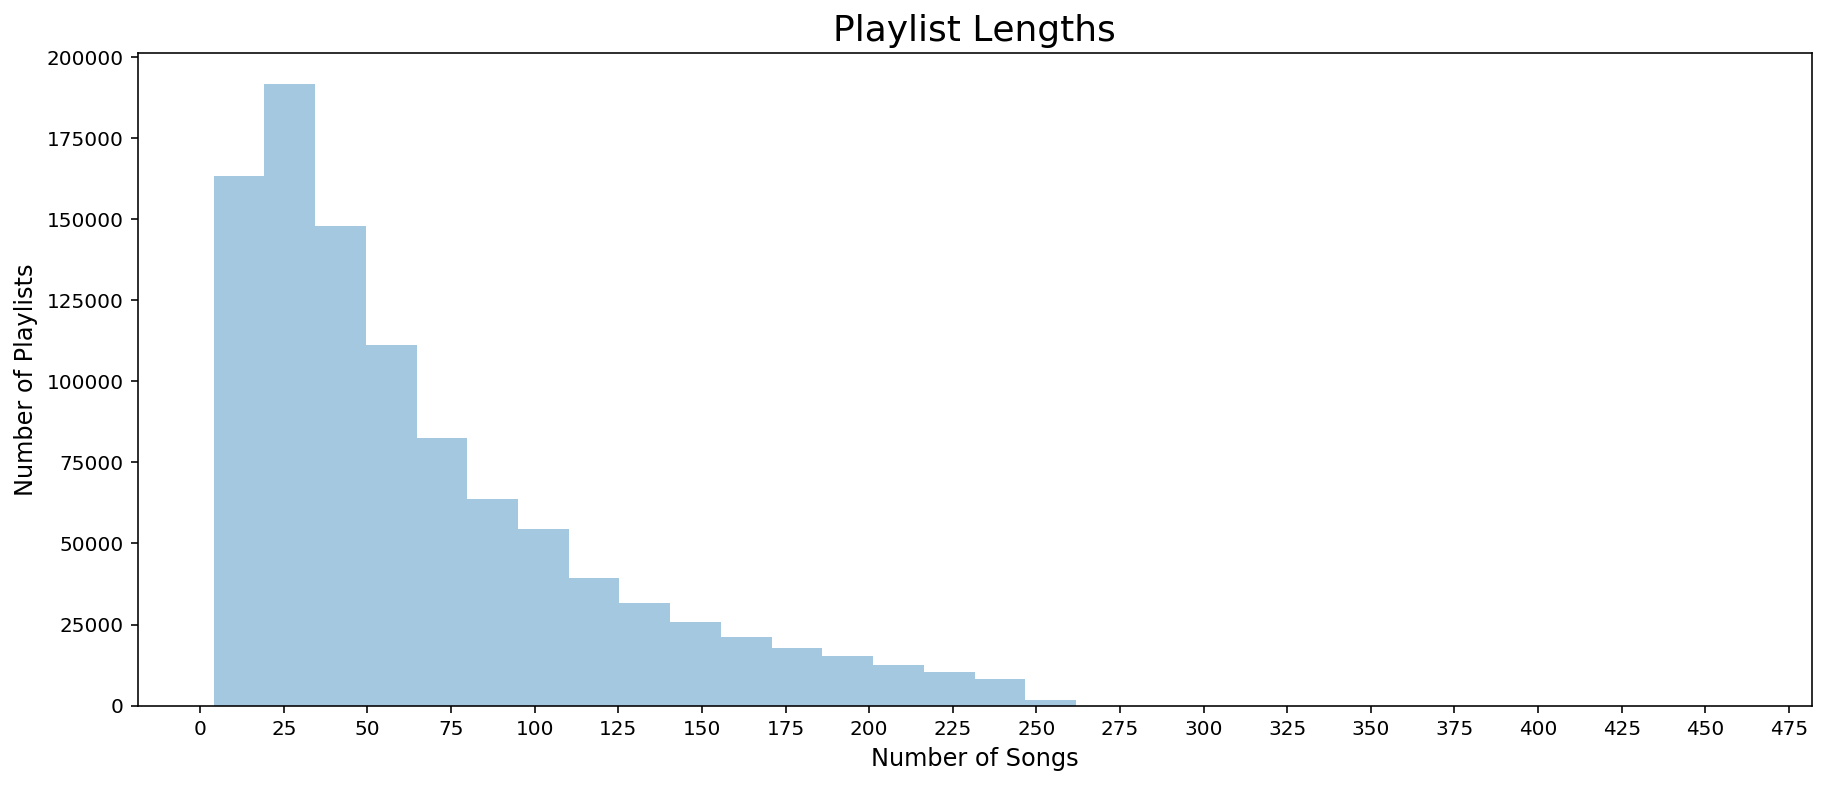

In [23]:
# Plot playlist length distribution
fig, subplot = plt.subplots(figsize=(15,6))
subplot.set_title("Playlist Lengths", fontsize=18)
sns.distplot(df_counts.song_count, bins=30, ax=subplot, kde=False);
subplot.set_xlabel("Number of Songs", fontsize=12)
subplot.set_ylabel("Number of Playlists", fontsize=12);

start, end = subplot.get_xlim()
subplot.xaxis.set_ticks(np.arange(0, end, 25))
fig.show()

<a name='s6b'></a>
## Artists
<a href=#index>back to index</a>

In [20]:
# Artist Popularity - measured by number of appearances
artist_playlist_count = display_time(session.query(Playlists.artist_name, func.count(Playlists.artist_name).label('count')).group_by(Playlists.artist_name).all)
df_artist_popularity = pd.DataFrame(artist_playlist_count).sort_values(by="count", ascending=False).reset_index(drop=True)
df_artist_popularity1 = df_artist_popularity.set_index(['artist_name'])

cols=['artist_name','count']
top20 = df_artist_popularity1[0:20]


Time to Execute: 397.01 seconds


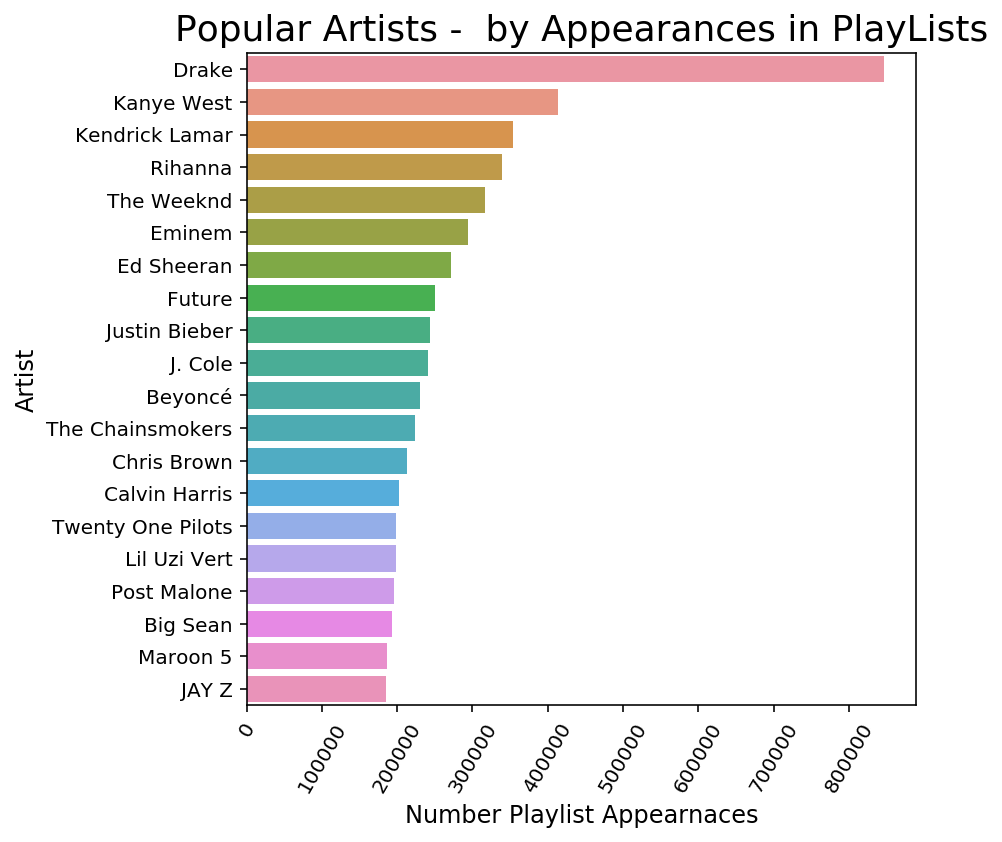

In [24]:
# Plot popular artists
fig, subplot = plt.subplots(figsize=(6,6))
subplot.set_title("Popular Artists -  by Appearances in PlayLists", fontsize=18)
sns.barplot(y=top20.index,
            x=top20['count'],
            orient="h", ax=subplot)
subplot.set_xlabel("Number Playlist Appearnaces", fontsize=12)
subplot.set_ylabel("Artist", fontsize=12);
subplot.tick_params(axis='x', labelrotation=60);

In [33]:
# Top tracks
track_playlist_count = display_time(session.query(Playlists.track_name, Playlists.artist_name, func.count(Playlists.track_uri).label('count')).group_by(Playlists.track_name).all)

Time to Execute: 481.26 seconds


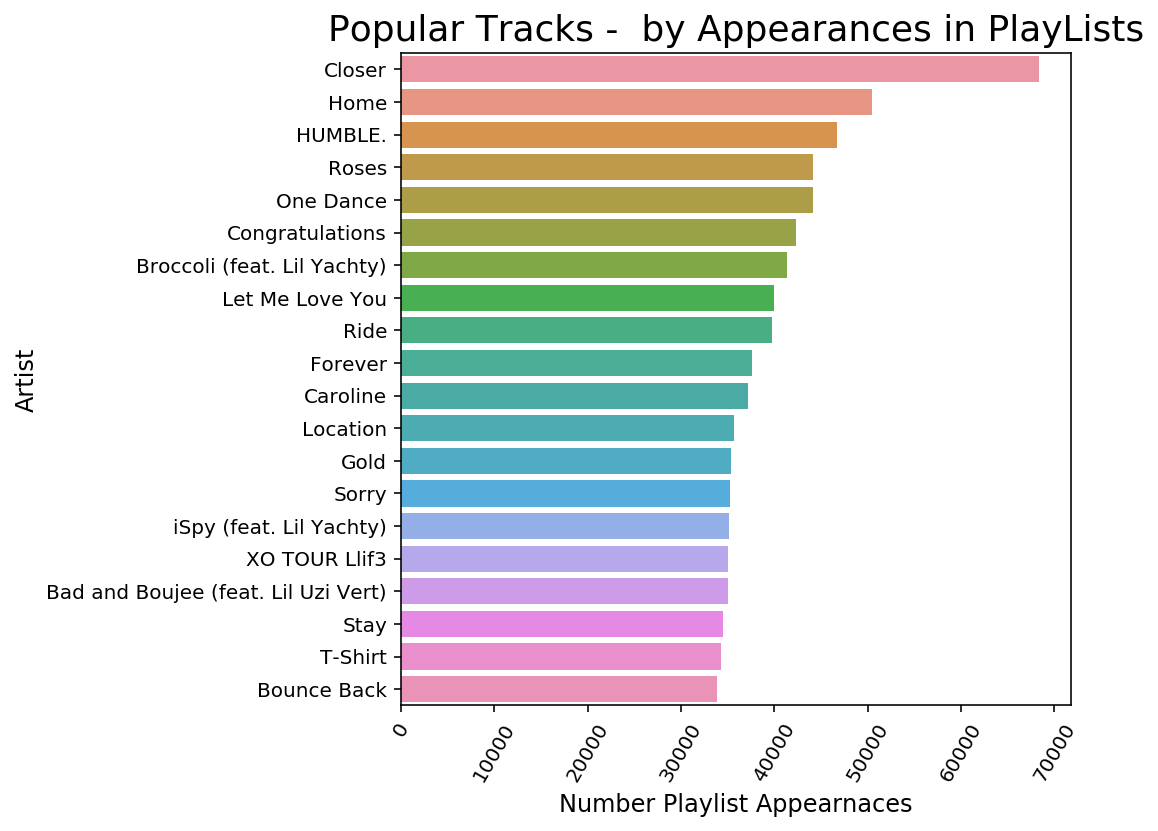

In [32]:

df_track_popularity = pd.DataFrame(track_playlist_count).sort_values(by="count", ascending=False).reset_index(drop=True)
df_track_popularity1 = df_track_popularity.set_index(['track_name'])

cols=['track_name','artiat_name', 'count']
top20tracks = df_track_popularity1[0:20]

fig, subplot = plt.subplots(figsize=(6,6))
subplot.set_title("Popular Tracks -  by Appearances in PlayLists", fontsize=18)
sns.barplot(y=top20tracks.index,
            x=top20tracks['count'],
            orient="h", ax=subplot)
subplot.set_xlabel("Number Playlist Appearnaces", fontsize=12)
subplot.set_ylabel("Artist", fontsize=12);
subplot.tick_params(axis='x', labelrotation=60);


In [19]:
df_artist_popularity1.describe()

,count
count,287688.000000
mean,230.612459
std,3868.568138
min,0.000000
25%,1.000000
50%,3.000000
75%,13.000000
max,847159.000000


In [20]:
np.median(df_artist_popularity1['count'])

3.0

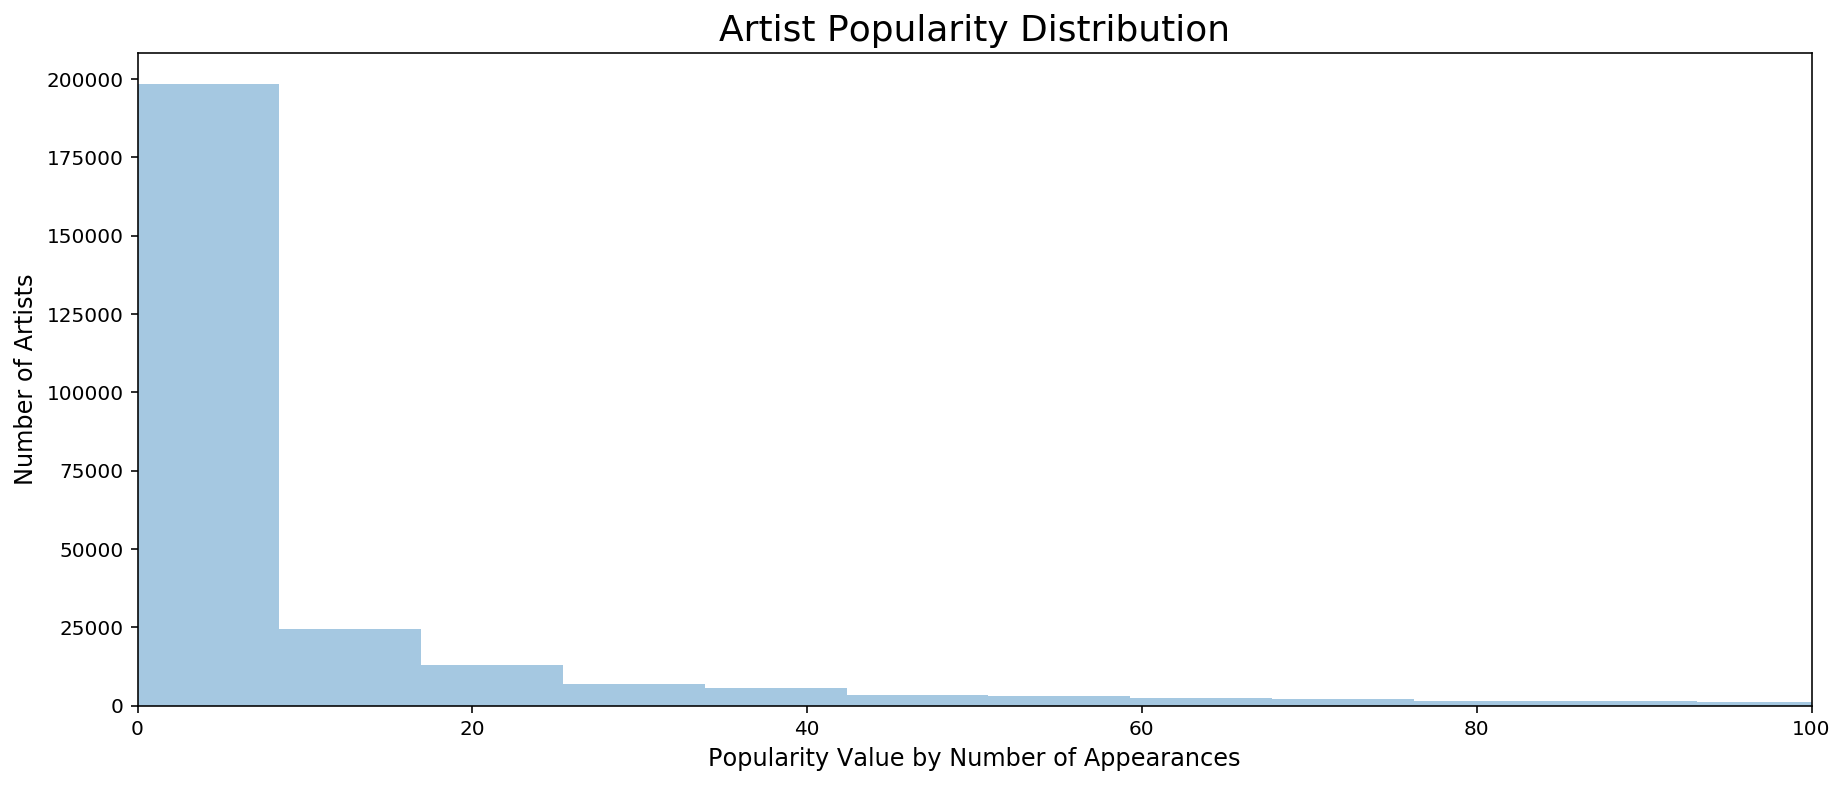

In [34]:
# distribution of artist appearances in playlists
fig, subplot = plt.subplots(figsize=(15,6))
subplot.set_title("Artist Popularity Distribution", fontsize=18)
sns.distplot(df_artist_popularity1['count'].values, bins=100000, ax=subplot, kde=False);
subplot.set_xlabel("Popularity Value by Number of Appearances", fontsize=12)
subplot.set_ylabel("Number of Artists", fontsize=12);
subplot.set_xlim((0,100))
# start, end = subplot.get_xlim()
# subplot.xaxis.set_ticks(np.arange(0, end, 25))
fig.show()

**NOTE:**
The top 20 are outliers.  75% of artists have 13 or fewer appearances.  The median number of appearances is only 3.  

In [22]:
# Artist Popularity Values
db_artist_popularity = display_time(session.query(Artists.artist_name, Artists.artist_popularity).all)
artist_popularity = pd.DataFrame(db_artist_popularity, columns=['artist', 'popularity']).sort_values(by='popularity', ascending=False).reset_index(drop=True)


Time to Execute: 6.74 seconds


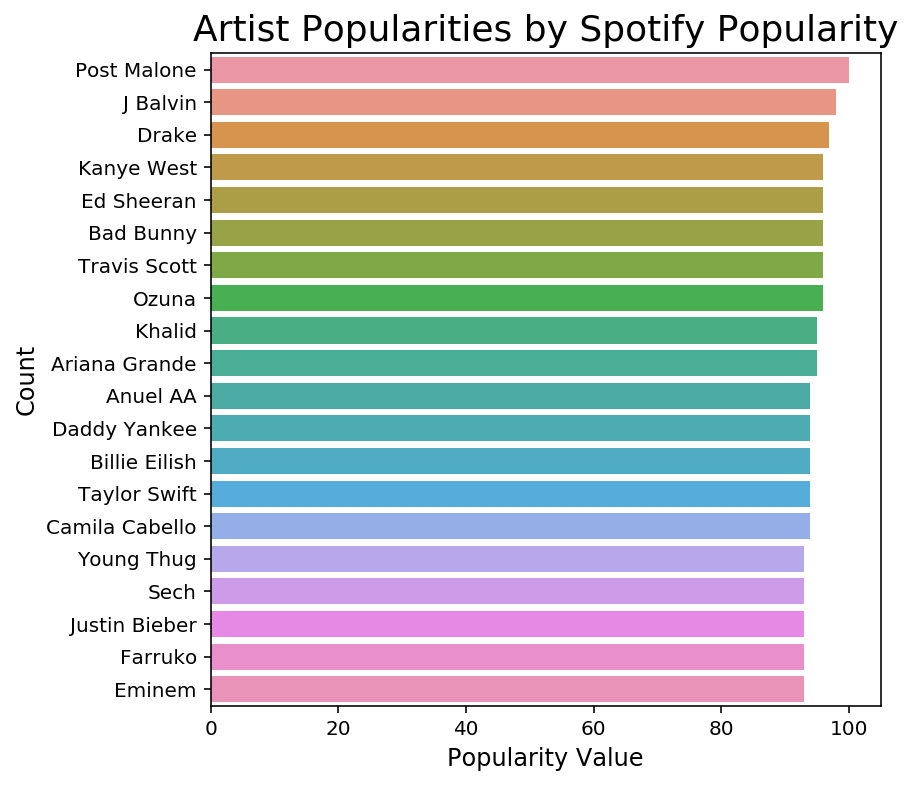

In [23]:
fig, subplot = plt.subplots(figsize=(6,6))
subplot.set_title("Artist Popularities by Spotify Popularity", fontsize=18)

sns.barplot(y=artist_popularity[:20]['artist'],
            x=artist_popularity[:20]['popularity'],
            orient="h", ax=subplot)

subplot.set_xlabel("Popularity Value", fontsize=12)
subplot.set_ylabel("Count", fontsize=12);

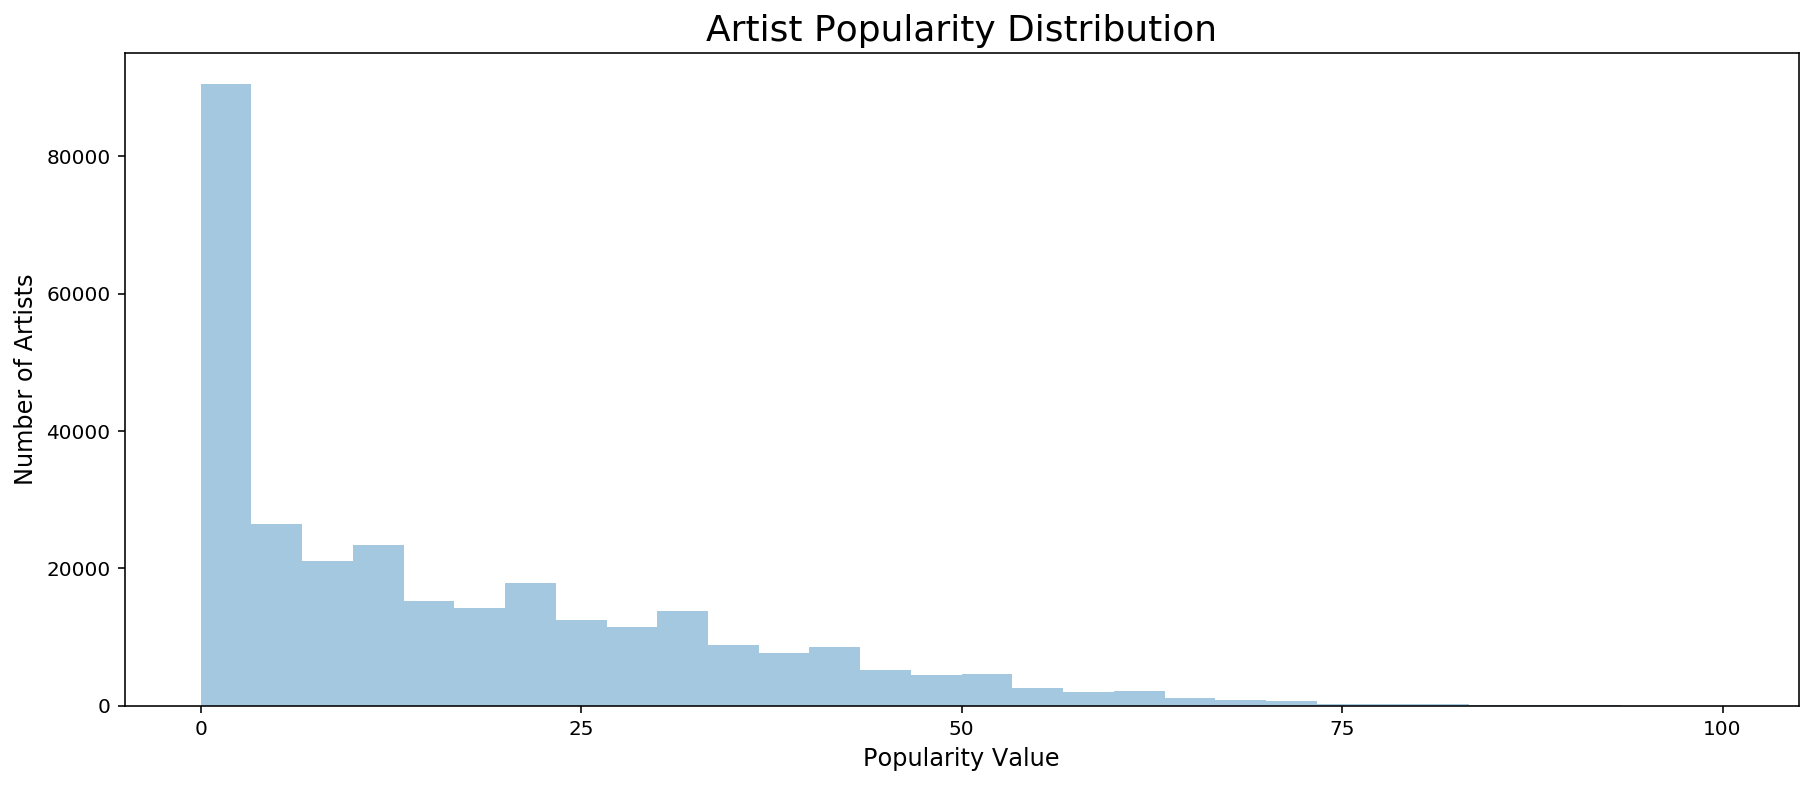

In [24]:
# distribution of Spotify Popularity Values
fig, subplot = plt.subplots(figsize=(15,6))
subplot.set_title("Artist Popularity Distribution", fontsize=18)
sns.distplot(artist_popularity.popularity, bins=30, ax=subplot, kde=False);
subplot.set_xlabel("Popularity Value", fontsize=12)
subplot.set_ylabel("Number of Artists", fontsize=12);

start, end = subplot.get_xlim()
subplot.xaxis.set_ticks(np.arange(0, end, 25))
fig.show()


### Note on Artist Popularity:
Spotify assigns a value of zero to the majority of artists' popularity. Using the Spotify Popularity value will not be useful.

In [25]:
artist_popularity.describe()

,popularity
count,296014.000000
mean,16.377198
std,16.619688
min,0.000000
25%,2.000000
50%,11.000000
75%,27.000000
max,100.000000


In [26]:
np.median(artist_popularity['popularity'])

11.0

### Artist Genres

In [27]:
artist_genres = pd.DataFrame(display_time(session.query(Artists.artist_name, Artists.genres).all))

Time to Execute: 0.46 seconds


In [28]:
artist_genres.head()

,artist_name,genres
0,Jane's Addiction with Body Count,
1,Alive In Wild Paint,dreamo
2,King Eider,"crossover prog,dutch prog"
3,Resorte,"latin alternative,latin metal,latin rock,mexic..."
4,Corey Russell,deep ccm


In [29]:
# create a list of unique genres
genres = np.concatenate([np.array(x.split(',')) for x in artist_genres.genres])
unique_genres = np.unique(genres)
print("Number of genres: {}".format(len(unique_genres)))


Number of genres: 3635


In [30]:
# count per genre
genres_count = pd.DataFrame(unique_genres, columns=['genre'])
genres_count['count'] = pd.Series(np.zeros(len(genres_count), dtype=int))
genres_count.set_index('genre', inplace=True, drop=True)

for g in tqdm(unique_genres, desc='counting genres'):
    genres_count.loc[g] = np.sum(genres==g)

genres_count.sort_values(by='count', inplace=True, ascending=False);

In [31]:
genres_count.head()

,count
genre,
,181365
pop,637
dance pop,594
rock,579
modern rock,525


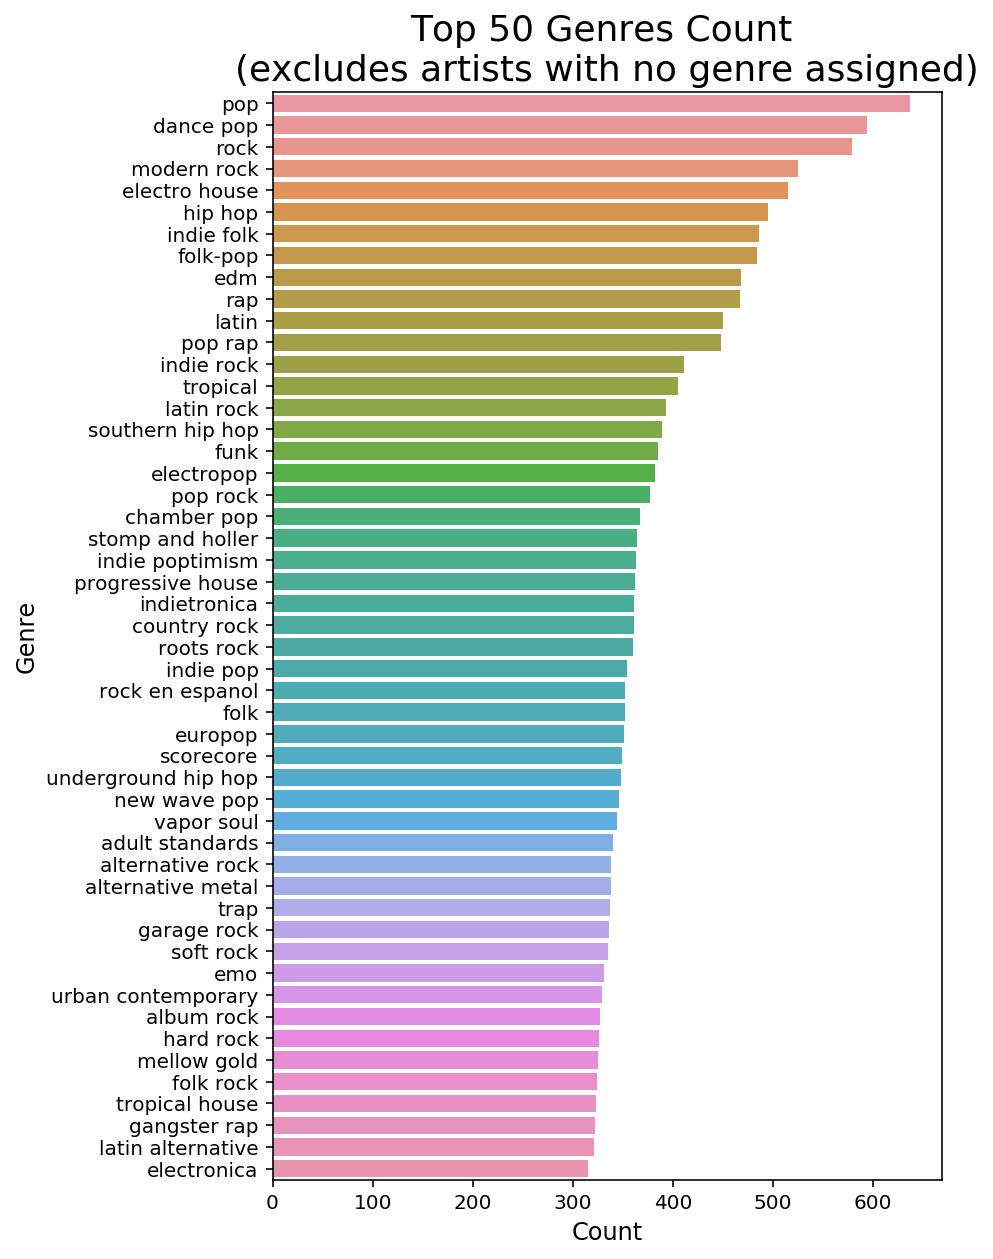

In [32]:
fig, subplot = plt.subplots(figsize=(6,10))
subplot.set_title("Top 50 Genres Count \n(excludes artists with no genre assigned)", fontsize=18)

sns.barplot(y=genres_count[1:51].index,
            x=genres_count[1:51]['count'],
            orient="h", ax=subplot)

subplot.set_xlabel("Count", fontsize=12)
subplot.set_ylabel("Genre", fontsize=12);

**Note:**
181365 of the artists (61%) have no genre assigned.

<a name='s6c'></a>
### Tracks
<a href=#index>back to index</a>

In [33]:
# fetch all db tracks
db_tracks = display_time(session.query(Tracks).all)

Time to Execute: 80.33 seconds


In [34]:
df_all_tracks = pd.DataFrame([x.__dict__ for x in db_tracks]).drop('_sa_instance_state', axis=1).set_index(['track_uri', 'artist_uri'])


In [35]:
df_all_tracks.describe()


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_popularity,valence
count,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06
mean,3.548610e-01,5.504661e-01,2.474320e+05,5.849420e-01,2.207979e-01,5.261050e+00,2.092522e-01,-9.659046e+00,6.550491e-01,8.935614e-02,1.199810e+02,3.879982e+00,1.267791e+01,4.757893e-01
std,3.543532e-01,1.845284e-01,1.560575e+05,2.659486e-01,3.493907e-01,3.558882e+00,1.899007e-01,5.623792e+00,4.753524e-01,1.152923e-01,2.992131e+01,4.717985e-01,1.391448e+01,2.699183e-01
min,0.000000e+00,0.000000e+00,1.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.230000e-02,4.270000e-01,1.842930e+05,3.890000e-01,0.000000e+00,2.000000e+00,9.580000e-02,-1.190900e+01,0.000000e+00,3.540000e-02,9.693200e+01,4.000000e+00,0.000000e+00,2.470000e-01
50%,2.150000e-01,5.650000e-01,2.252930e+05,6.220000e-01,6.020000e-04,5.000000e+00,1.280000e-01,-8.176000e+00,1.000000e+00,4.710000e-02,1.200060e+02,4.000000e+00,8.000000e+00,4.660000e-01
75%,6.910000e-01,6.890000e-01,2.783070e+05,8.090000e-01,4.210000e-01,8.000000e+00,2.640000e-01,-5.825000e+00,1.000000e+00,8.400000e-02,1.380510e+02,4.000000e+00,2.100000e+01,6.970000e-01
max,9.960000e-01,9.960000e-01,6.047705e+06,1.000000e+00,1.000000e+00,1.100000e+01,1.000000e+00,4.923000e+00,1.000000e+00,9.710000e-01,2.499870e+02,5.000000e+00,8.800000e+01,1.000000e+00


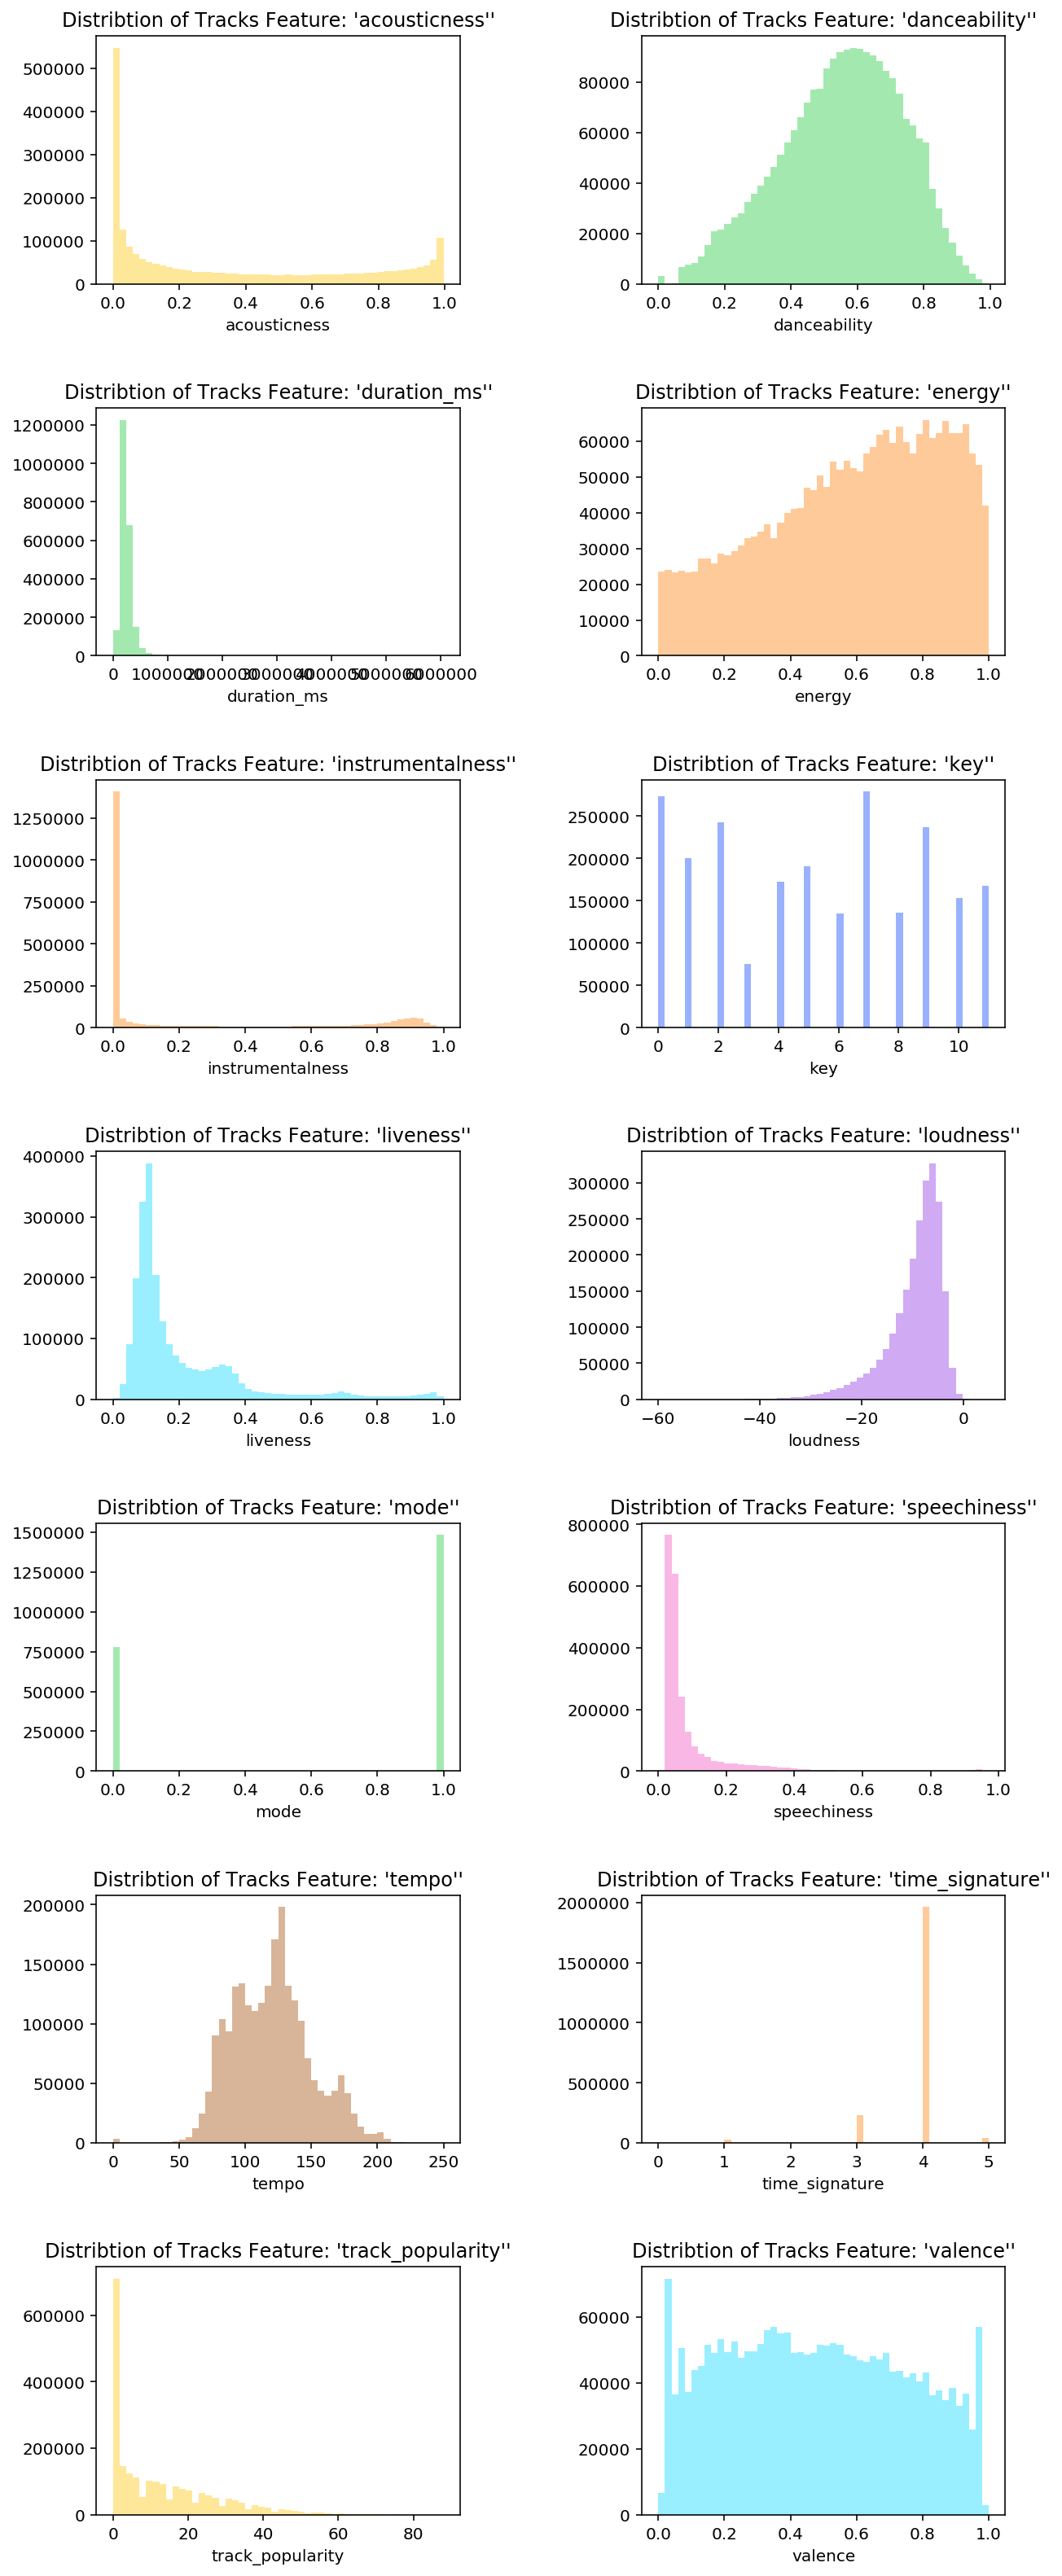

In [36]:
features = df_all_tracks.columns
num_features = len(features)

colors = sns.color_palette("bright", num_features*2)

fig, subplot  = plt.subplots(nrows=int(num_features/2), ncols=2, figsize=(10,len(features)*2))
# fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=.5)

for i, ax in enumerate(np.ravel(subplot)):
    sns.distplot(df_all_tracks[features[i]], kde=False, ax=ax, color=colors[random.randint(0,num_features)])
    ax.set_title("Distribtion of Tracks Feature: '{}''".format(features[i]))

### **Note:**
### The following accoustic features are most useful:
- danceability
- energy
- key
- liveness
- loudness
- speechiness
- tempo
- valence

In [49]:
# Count records that seem to have largely missing information

# Create a counting dataframe
counts = [np.sum(df_all_tracks[f]==0) for f in features]
zero_counts = pd.DataFrame(counts, columns=['count'], index=features)
zero_counts['percentages'] = np.array(counts)/len(df_all_tracks)
zero_counts

,count,percentages
acousticness,870,0.000385
danceability,3133,0.001385
duration_ms,0,0.000000
energy,439,0.000194
instrumentalness,607663,0.268688
key,273848,0.121086
liveness,1084,0.000479
loudness,0,0.000000
mode,780140,0.344951
speechiness,3130,0.001384


**NOTE:**
> Track popularity is not populated in a sufficient number of records to be useful

> All other values of zero either have a meaning or are not of sufficient number to warrant addressing.

<a name='s7'></a>
# 7. Baseline Model 1 (Gensim)
<a href=#index>back to index</a>

## Building a Vocabulary of Songs
The baseline model uses embeddings to find similarities between songs.  The embeddings are built from playlists, where the playlist serves as a sentence made up of songs.

Similarities between songs are determined by their cosine distance with other songs.

To speed up to building of the enbedding, an extract is made from the database which will serve as a document of sentences where each line in the file is a space delimited list of playlist songs.

From the DB, the following view is created which is subseqntly extracted as a CSV file:<br>

`CREATE VIEW playlist_tracks_uris AS SELECT t.playlist_id, group_concat(t.track_uri, ' ')  FROM playlists t GROUP BY  t.playlist_id;`



In [26]:
# Iterator that yields the songs for each playlist in the CSV file
class Playlist_URIs(object):
    """
    Playlist generator that yileds the track uris in a playlist.
    Yields one playlist at a time.
    """
    def __init__(self,
                 filename:str=os.path.join(data_path,'playlist_tracks.csv'),
                 name:str=None,
                 iters:int=None):
        self.filename     = filename
        self.length       = len(open(self.filename).readlines())
        self.name         = name
        self.count        = 0
        self.iters        = iters
        print("Creating Playlist Track Listing Generator:")
        print("\tlength     : ", self.length)
    
    def __iter__(self):
        
        self.count += 1
        progbar = tqdm(total=self.length, desc="{}:{}/{}".format(self.name, self.count, self.iters+1))
        
        # yield a list of lists; sentences = [["cat", "say", "meow"], ["dog", "say", "woof"]]
        for line in open(self.filename, 'r'):
            progbar.update(1)
            yield line.split('\t')[1].split(' ') # tab-delimited CSV file
            
        progbar.close()    

In [30]:
# Create a generator object to use while building the embedding
corpus_file = 'playlist_tracks.csv'
corpus_filepath = os.path.join(data_path, corpus_file)

iters = 5
playlists_gen = Playlist_URIs(filename=corpus_filepath,
                              name="Building Vectors",
                              iters=iters) 

Creating Playlist Track Listing Generator:
	length     :  999001


In [33]:
# Build a gensim model including a word embedding
model = gensim.models.Word2Vec(sentences=playlists_gen,
                               workers = 8,    # number of processors
                               sg = 0,         # 1=skip-gram, 0=CBOW
                               iter=iters      # training iterations - default=5
                              )

# about 5 minutes per iteration with 4 processors // 2 min per iteration with 8

### Model Attributes
#### wv
> This object essentially contains the mapping between words and embeddings. After training, it can be used directly to query those embeddings in various ways. See the module level docstring for examples.

#### vocabulary
> This object represents the vocabulary (sometimes called Dictionary in gensim) of the model. Besides keeping track of all unique words, this object provides extra functionality, such as constructing a huffman tree (frequent words are closer to the root), or discarding extremely rare words.

## Test the model
Get 10 'words' from the model's vocabulary.

In [35]:
for i, word in enumerate(model.wv.vocab):
    if i == 10:
        break
    print(word)

spotify:track:2d7LPtieXdIYzf7yHPooWd
spotify:track:0y4TKcc7p2H6P0GJlt01EI
spotify:track:6q4c1vPRZREh7nw3wG7Ixz
spotify:track:54KFQB6N4pn926IUUYZGzK
spotify:track:0NeJjNlprGfZpeX2LQuN6c
spotify:track:2kuFVY6hWX6yavTiWHE3SQ
spotify:track:66mmvchQ4C3LnPzq4DiAI3
spotify:track:4gFxywaJejXWxo0NjlWzgg
spotify:track:6wQSrFnJYm3evLsavFeCVT
spotify:track:3ZjnFYlal0fXN6t61wdxhl


In [36]:
# Show the vector value for one word
model.wv.get_vector(word)

array([ 0.7069466 ,  0.06713159,  1.208902  ,  0.6771693 , -0.54616696,
       -0.70742685,  0.5276316 , -0.12770323, -0.64619964,  0.9499749 ,
       -0.97601163,  0.96703625, -1.119984  , -0.9927392 ,  0.07375626,
       -0.05005192, -0.8225439 , -1.1098657 ,  0.02311942, -0.2789549 ,
       -1.1482902 ,  1.0357076 , -0.23925377, -0.04726438, -1.5424833 ,
        1.7266434 , -0.2916497 ,  0.00344536,  0.10040055,  0.9528068 ,
       -0.6870445 ,  0.00618318,  2.2632582 ,  0.22976692,  0.46539795,
        0.94254154, -0.07955167, -0.7013011 , -0.39785764,  0.6679074 ,
        0.45688424,  0.7499335 ,  0.7195104 , -0.56014305,  1.2567282 ,
        0.15754141, -0.14955628, -0.44199228, -0.25695285,  0.49496347,
       -0.69732887, -0.18750341, -0.15788026, -0.32441205,  0.35067946,
       -1.1661924 , -0.517909  , -1.021437  , -0.37492803, -0.25628343,
       -0.25885084, -0.60592765,  0.25696144,  0.9112606 , -0.08946801,
       -0.26725456, -1.2961123 , -0.25671923,  0.5921087 ,  0.80

In [37]:
# only the embedding vectors are needed - so avoid saving the whole model

kv_filepath = os.path.join(data_path, 'playlists_BOW1')
model.wv.save(kv_filepath)

# reload saved vectors
model_v = KeyedVectors.load(kv_filepath, mmap='r')

NameError: name 'KeyedVectors' is not defined

In [ ]:
# Get a song as a seed for a test playlist
db_track = display_time(session.query(Playlists.track_name, 
                                Playlists.track_uri,
                                Playlists.artist_uri,
                                Playlists.album_uri).filter(Playlists.track_name=="Free Fallin'").distinct().first)
print("Artist: {}".format(get_artists([db_track.artist_uri])[0]['name']))
print("Track:  {}".format(db_track.track_name))

In [ ]:
# Find 10 similar songs 
playlist = np.array(model_v.similar_by_word(rv.track_uri, topn=10, restrict_vocab=None))
playlist

In [ ]:
# Get the similar songs from Spotify to show their details, including preview link (if available)
sp_playlist = get_tracks(playlist[:,0])
print ("PLAYLIST RECOMMENDATION")
print ("-----------------------")

for t in sp_playlist:
    print("Artist       : ", t['artists'][0]['name'])
    print("Track        : ", t['name'])
    print("Track Preview: ", t['preview_url'] )
    print()

<a name='s7'></a>
# 8. Baseline Model 2 (Collaborative Filtering/kNN)
<a href=#index>back to index</a>

Collaborative filtering relies on similarities between user behavior to make predictions. In recommendation systems, a matrix is often encoded to represent user behavior. In this model/context, this matrix represents playlists (in rows) vs. songs that are present in a given playlist (in columns), where a 1 represents a song being present. Given the large volume of songs, this matrix is very sparse. This baseline approach builds this sparse matrix using SKLearn's CountVectorizer and then uses cosine distance to make predictions using a k-nearest neighbors model. Recommendations are randomly drawn from similar playlists while avoiding duplication with the input set. In short:

1. Build a sparse matrix for playlists X tracks
2. Fit a kNN model to this data using cosine distance
3. Find nearest playlists using this model given a list of songs
4. Select songs from nearest neighbor lists as recommendations

**Note:**
For simplicity in this proof-of-concept, and because this model does not rely on song metadata (e.g. acoustic features), this example just pulls data directly from the CSV files themselves in lieu of the SQLite database used for the general EDA above. This example just runs a test using the first 10 CSV files provided in the data ('songs0.csv' through 'songs9.csv').

### Helper methods

In [92]:
''' The staff provided data has filenames 'songs0.csv' through 'songs999.csv'
    This function returns a single dataframe containing the desired CSV files.
    Args:
        1) file_nums:  list ... List of file #s to read (e.g. 0, 1, 2 ... 999); default is to just read 'songs0.csv'
        2) songs_dir:  str  ... Where the songs CSVs reside; default is 'songs/' '''
def read_songs_csv(file_nums: list = [0], songs_dir: str = '../../data/songs/') -> pd.core.frame.DataFrame:
    # check for valid input
    if any(i < 0 for i in file_nums) or any(i > 999 for i in file_nums) or len(file_nums) == 0:
        print('ERROR - read_songs_csv: Bad parameters; file numbers are out of bounds, or list is empty')
        return
    
    # put all listed songs CSV #s into a dataframe; adds 1000*i to each pid to ensure uniqueness among files read
    dfs = []
    for i in file_nums:
        df = pd.read_csv(songs_dir + 'songs' + str(i) + '.csv')
        df['pid'] = df['pid'] + (i*1000)
        dfs.append(df)
    
    return pd.concat(dfs)

''' This function takes a DF as produced above, and based on the provided field, generates a space-delimited 
    list of strings per pid for that field. For example, the default will generate a string of track_uris per pid. 
    Strips the URI prefix as well. '''
def gen_corpus_by_pid(df:pd.core.frame.DataFrame, col:str='track_uri', prefix:str='spotify:track:'):
    pids = df['pid'].unique()
    strs = []
    
    for pid in pids:
        next_str = df.loc[df['pid'] == pid][col].str.lstrip(prefix)
        strs.append(next_str.str.cat(sep=' '))
        
    return strs, pids

''' Takes a list of songs and converts them into a single row of a sparse matrix based on a larger list of songs. '''
def convert_songs_to_csr(songs:list, all_songs:list):
    return csr_matrix([x in songs and 1 or 0 for x in all_songs])

''' Returns a list of random songs given a full "vocabulary" of songs. '''
def get_random_songs(all_songs:list, num_songs:int=10) -> list:
    return [all_songs[i] for i in np.random.randint(0, len(all_songs), num_songs)]

''' Returns a list of song recommendations from a given set of nearest neighbors. Takes the original input list as 
    well to avoid duplication. '''
def get_recommendations_from_neighbors(df, pids, input_songs, num_recos=10):
    recos = []
    cur_pid = 0
    while cur_pid < len(pids):
        playlist = df.loc[df['pid'] == pids[cur_pid]].track_uri.str.lstrip('spotify:track:').tolist()
        
        i = 0
        while len(recos) < num_recos:
            if playlist[i] not in input_songs:
                recos.append(playlist[i])
            i += 1
            if i == len(playlist):
                cur_pid += 1
                break
                
        
        if len(recos) == num_recos:
            break
        
        if cur_pid == len(pids):
            print('Could not find enough recommendations!')
    
    return recos
        
# for convenience, constants for reading all files/a random assortment/first 10
ALL_FILES = np.arange(0, 1000, 1) # WARNING: this will take awhile
RANDOM = np.random.randint(0, 1000, 10)
FIRST_10 = np.arange(0, 10, 1)

### Assembling a test data set and building a model

In [93]:
# Create a DF of the 1st 10 files for testing
test_df = read_songs_csv(FIRST_10)
test_df.head()

,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name
0,0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook
1,0,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone
2,0,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit)
3,0,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified
4,0,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot


In [94]:
# Generate corpus for track_uris for the test dataframe; this is simply a long string of the URIs per playlist
corpus, pids = gen_corpus_by_pid(test_df)

display(len(corpus))
display(len(pids))

10000

10000

In [95]:
# build count matrix for playlists vs tracks
vectorizer = CountVectorizer(lowercase=False)
matrix = vectorizer.fit_transform(corpus)

# fit a nearest neighbors model using cosine distance
neighbors_model = NearestNeighbors(metric='cosine')
neighbors_model.fit(matrix)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

### Make some recommendations

We will 'test' the model with 2 basic types of inputs:

- The first 10 songs of the 1st playlist provided to the data set (e.g. a truncated version of the 1st playlist)
- Some random playlists of 10 songs each

In [96]:
TRACK_PREFIX = 'spotify:track:'

# prepare the test inputs
first10_songs = test_df[test_df.pid == 0].track_uri.str.lstrip(TRACK_PREFIX)[:10].tolist()
rand10_songs1 = get_random_songs(vectorizer.get_feature_names())
rand10_songs2 = get_random_songs(vectorizer.get_feature_names())

song_inputs = [ first10_songs, rand10_songs1, rand10_songs2 ]

sparse_inputs = [ convert_songs_to_csr(first10_songs, vectorizer.get_feature_names()), 
                  convert_songs_to_csr(rand10_songs1, vectorizer.get_feature_names()),
                  convert_songs_to_csr(rand10_songs2, vectorizer.get_feature_names()) ]

# check; should each equal 10
for i in range(3):
    display(sparse_inputs[i].sum(axis=1))

matrix([[10]])

matrix([[10]])

matrix([[10]])

In [97]:
# find nearest neighbors for each input list
neighbors = []
for i in sparse_inputs:
    nearest = neighbors_model.kneighbors(i, return_distance=False)
    neighbors.append(nearest)
    print(nearest)

[[   0 5665 4195 9715 8261]]
[[8758 3899 9434 6879 7821]]
[[ 390 5348 8374 5828 9084]]


**NOTE**:
Since we used the 1st 10 CSV files, these neighbor indices coincide with playlist ID. However if we had provided a different set of CSV files (with different pids) we may need to index into the earlier-obtained pids array in order to find the correct ID. For simplicity in this early step, we proceed with the neighbor indices on-face.

In [98]:
# get song recommendations from neighbors
recos = []
for i, n in enumerate(neighbors):
    songs = get_recommendations_from_neighbors(test_df, n[0], song_inputs[i])
    recos.append(songs)
    print(songs)

['2gam98EZKrF9XuOkU13ApN', '4Y45aqo9QMa57rDsAJv40A', '1HwpWwa6bnqqRhK8agG4RS', '20ORwCJusz4KS2PbTPVNKo', '7k6IzwMGpxnRghE7YosnXT', '1Bv0Yl01xBDZD4OQP93fyl', '4omisSlTk6Dsq2iQD7MA07', '7xYnUQigPoIDAMPVK79NEq', '6d8A5sAx9TfdeseDvfWNHd', '4pmc2AxSEq6g7hPVlJCPyP']
['5rP5p9u2H4hrlLkaxOYDq9', '6og8Ao1L9I8QPbCAFCymWb', '2oH1xCOGyY58Dd9fedIqTY', '0AQSMyOpBCHCAW0IdO3m01', '5KVzrKW9MzM2MEQgjjZjZb', '17i5jLpzndlQhbS4SrTd0B', '0N6TuzP1jXjTT6gJO1tyFN', '2xgFoVYVZ0Po7nYA8sHe2A', '3DzMT13HJV7EsbVbNZZJZQ', '2pr8JoglUbFth4eJY8WBpM']
['5kaX9u8USNLqK3pnvzWwSk', '6Tv5UgrQmAWFVsfLPibDIz', '7KFUj2MunvS4cbauF04r6w', '0oEbCQvG8L9vzh6yoxrPJx', '2VpdG2QLhVv6qAPdDt9Ipr', '1KhskNApqcI0XuIbbeERlw', '799nn8g4CxgRKB30WN2kuZ', '7K1F1yaVLYQkBsccHH0Pu8', '3OzmHWQquuzhXy9om4JNcN', '6yfYzKBmFDfNPOgyz3KI0d']


In [107]:
# helper to display track info
def display_track_info(df, uri):
    track = df[df.track_uri == TRACK_PREFIX + uri].iloc[0]
    print(track.artist_name, '-', track.track_name)

# display input --> results
for i in range(3):
    print('\nPLAYLIST', i+1)
    
    print('\nINPUT:')
    for uri in song_inputs[i]:  
        display_track_info(test_df, uri)
    
    print('\nRECOMMENDS:')
    for uri in recos[i]:  
        display_track_info(test_df, uri)


PLAYLIST 1

INPUT:
Missy Elliott - Lose Control (feat. Ciara & Fat Man Scoop)
Britney Spears - Toxic
Beyoncé - Crazy In Love
Justin Timberlake - Rock Your Body
Shaggy - It Wasn't Me
Usher - Yeah!
Usher - My Boo
The Pussycat Dolls - Buttons
Destiny's Child - Say My Name
OutKast - Hey Ya! - Radio Mix / Club Mix

RECOMMENDS:
Nelly Furtado - Promiscuous
Jesse McCartney - Right Where You Want Me - Radio Edit Version
Jesse McCartney - Beautiful Soul
Jesse McCartney - Leavin'
Cassie - Me & U
Omarion - Ice Box
Avril Lavigne - Sk8er Boi
Chris Brown - Run It!
Beyoncé - Check On It - feat. Bun B and Slim Thug
Destiny's Child - Jumpin', Jumpin'

PLAYLIST 2

INPUT:
Lyle Mays - Highland Aire
Mo Lowda & the Humble - I Don't Know
Bassnectar - Gnar
Fra Nefarious - Paradise - Original Mix
Rada - the night
Kenny Loggins - What a Fool Believes - Live
The Strokes - Tap Out
Original Broadway Cast Recording - Made in America (feat. Michael Lanning)
Paul McCartney - I've Just Seen A Face - 2013 Remaster
Root

### Comments & Issues

As described, this model is extremely basic: it finds the "closest" playlist to the one provided, and simply spits out songs from this closest neighbor(s). The most notable problem is that since we are only spitting out songs from a given playlist in sequence, the recommendations are likely to be very similar. While this may work very well for highly "focused" input, as exemplified by the first sample input above (we fed 10 songs from a playlist already in the matrix, and naturally the model spits back songs from the same playlist!), it works terribly for mixed playlists, as seen in the latter examples; the eclectic randomly selected lists spit out very one-dimensional recommendations in return which may or may not be relevant. 

We may be able to make small improvements by doing things like picking songs at random from X number of closet neighbors. 

<a name='s7'></a>
# 9. Next Steps
<a href=#index>back to index</a>

This document presents our methodology for data wrangling, some exploratory analysis and 2 initial models for recommendation systems.

Further exploration, refinement and testing of models is the primary next step. Alongside that, it is important to determine how to assess "accuracy"/relevance and present recommendation results. Finally we will implement and present our model results via Github pages for our final submission.

In [ ]:
connection.close()